# 一个小型CNN分类器的demo

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 检查 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [2]:
# CIFAR-10 图像归一化和数据增强
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 下载训练集和测试集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


# 简单 CNN 模型


In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64*8*8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

定义损失函数和优化器

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

训练模型（小规模演示，1 个 epoch）

In [20]:
for epoch in range(1):  # demo 只跑 1 个 epoch
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:  # 每 100 个 batch 打印一次
            print(f"[{epoch+1}, {i+1}] loss: {running_loss/100:.3f}")
            running_loss = 0.0

print("Finished Training")


[1, 100] loss: 0.020
[1, 200] loss: 0.019
[1, 300] loss: 0.020
[1, 400] loss: 0.031
[1, 500] loss: 0.016
[1, 600] loss: 0.018
[1, 700] loss: 0.031
Finished Training


测试模型

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100*correct/total:.2f}%")


Accuracy on test set: 69.63%


可视化

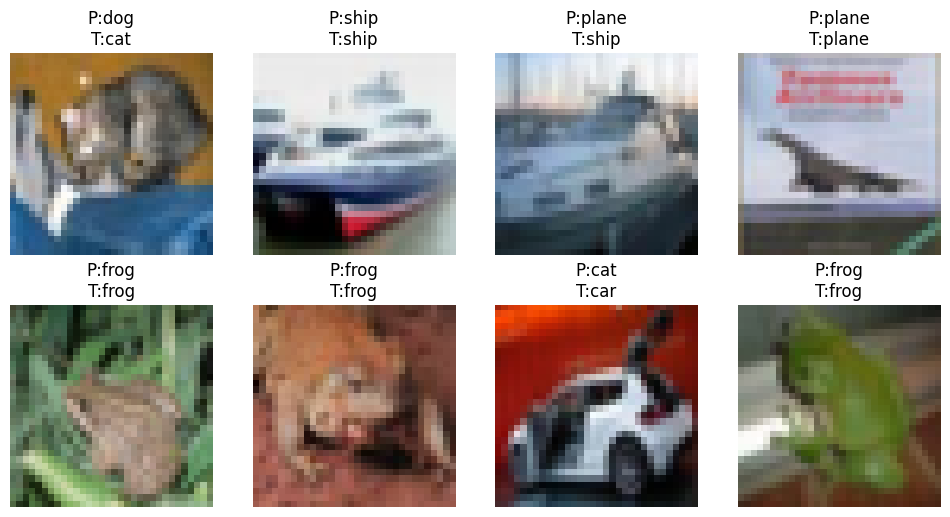

In [23]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# 转到 CPU 绘图
images = images.cpu()
predicted = predicted.cpu()
labels = labels.cpu()

fig, axes = plt.subplots(2, 4, figsize=(12,6))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0) * 0.5 + 0.5  # 反归一化
    ax.imshow(img)
    ax.set_title(f"P:{classes[predicted[i]]}\nT:{classes[labels[i]]}")
    ax.axis('off')
plt.show()
